In [1]:
from scipy import signal
from scipy import misc

%matplotlib inline
%matplotlib notebook
%pylab

import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import axes3d
from challenge.starGen import *
from solver.starSolve import *

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
stars_xyzm = np.array(genStars())
numBrights = 433

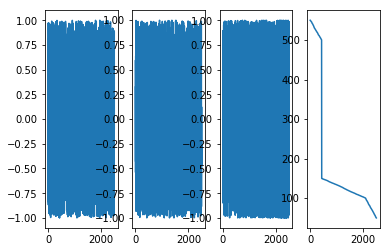

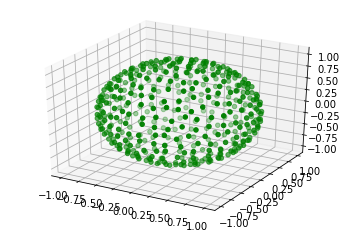

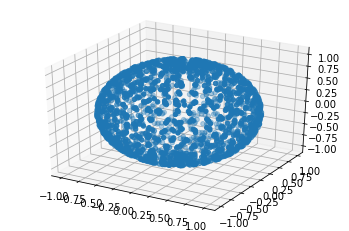

In [3]:
fig = plt.figure()
ax1 = fig.add_subplot(141)
ax1.plot(stars_xyzm[:,0])
ax1 = fig.add_subplot(142)
ax1.plot(stars_xyzm[:,1])
ax1 = fig.add_subplot(143)
ax1.plot(stars_xyzm[:,2])
ax1 = fig.add_subplot(144)
ax1.plot(stars_xyzm[:,3])
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(stars_xyzm[:numBrights,0], 
            stars_xyzm[:numBrights,1],
            stars_xyzm[:numBrights,2],c='green')
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(stars_xyzm[numBrights:,0], 
            stars_xyzm[numBrights:,1],
            stars_xyzm[numBrights:,2])
plt.show()



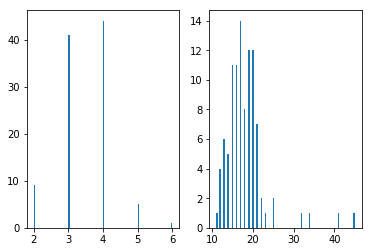

2 6
11 45


In [4]:
# Check Viewable, brights only
brights = stars_xyzm[:numBrights,:]
res = []
res2 = []
for ii in range(100):
        target = normalizeV(np.random.rand(3))
        viewable, viewable_idx = selectViewable(brights, target)
        res.append(len(viewable_idx)) 
        viewable, viewable_idx = selectViewable(stars_xyzm, target)
        res2.append(len(viewable_idx)) 
fig = plt.figure()
ax = fig.add_subplot(121)
ax.hist(res, bins=100)
ax = fig.add_subplot(122)
ax.hist(res2, bins=100)
plt.show()

print(min(res),max(res))
print(min(res2),max(res2))

In [5]:
# Let's make the triangles!
triangles, indexes = genCatalog(stars_xyzm)
print(len(triangles))

34106


In [6]:
print(np.corrcoef(triangles[:,0], triangles[:,1])[0,1])
#print(np.corrcoef(triangles[:,0], triangles[:,2])[0,1])
#print(np.corrcoef(triangles[:,0], triangles[:,3])[0,1])
#print(np.corrcoef(triangles[:,0], triangles[:,4])[0,1])
#print(np.corrcoef(triangles[:,1], triangles[:,2])[0,1])
#print(np.corrcoef(triangles[:,1], triangles[:,3])[0,1])
#print(np.corrcoef(triangles[:,1], triangles[:,4])[0,1])
#print(np.corrcoef(triangles[:,2], triangles[:,3])[0,1])
#print(np.corrcoef(triangles[:,2], triangles[:,4])[0,1])
#print(np.corrcoef(triangles[:,3], triangles[:,4])[0,1])


0.4066493206583812


In [11]:
# Start Generating a set of stars
target = np.random.rand(3)
target = target/np.linalg.norm(target)
viewable, viewable_idx = selectViewable(stars_xyzm, target)
noise = np.random.rand(viewable.shape[0], viewable.shape[1]) * 0.0001
viewable += noise
print("Target: " + target.__str__())
print("Num Viewable: %d" % len(viewable))

# Quat from target to reference vector 0,0,1
quat = quatBetweenVecs(target,np.array([0,0,1]))
# Rotate by Quat

viewable[:,:3] = rotateByQuat(quat, viewable[:,:3])


Target: [0.99400562 0.05100901 0.09670008]
Num Viewable: 18


In [12]:
vtriangles,vindexes = findTriangles(viewable)
print("Num View Triangles %d" % len(vtriangles))

Num View Triangles 87


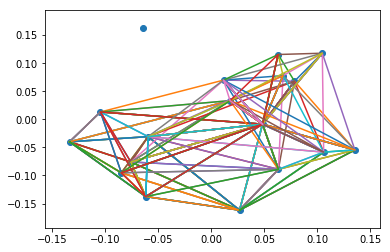

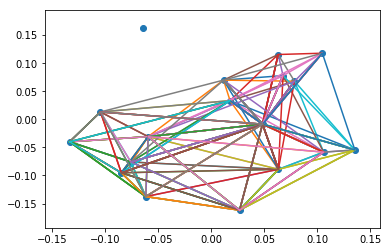

In [13]:
pixelCords = []
for v in viewable:
    x = v[0]/v[2]
    y = v[1]/v[2]
    pixelCords.append([x,y])
pixelCords = np.array(pixelCords)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(pixelCords[:,0], pixelCords[:,1])

for tri in vindexes:
    a = pixelCords[tri[0]]
    b = pixelCords[tri[1]]
    c = pixelCords[tri[2]]
    
    ax1.plot([a[0],b[0],c[0],a[0]],[a[1],b[1],c[1],a[1]])

realCords = []
for v in stars_xyzm[viewable_idx,:3]:
    x = v[0]/v[2]
    y = v[1]/v[2]
    realCords.append([x,y])
realCords = np.array(pixelCords)

    
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(pixelCords[:,0], pixelCords[:,1])

for i,j,k in indexes:
    if i in viewable_idx and j in viewable_idx and k in viewable_idx:
        i = viewable_idx.index(i)
        j = viewable_idx.index(j)
        k = viewable_idx.index(k)
        a = pixelCords[i]
        b = pixelCords[j]
        c = pixelCords[k]
    
        ax1.plot([a[0],b[0],c[0],a[0]],[a[1],b[1],c[1],a[1]])

    

[(10, 10), (135, 135), (914, 914), (1062, 1062), (1145, 1145), (1218, 1218), (1443, 1443), (2200, 2200), (334, 334), (450, 450), (1951, 1951), (587, 587), (1791, 1791), (1462, 1462), (2084, 2084), (1818, 1818), (461, 65)]
0.8888888888888888


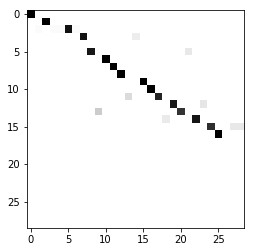

In [14]:
vtriangles,vindexes = findTriangles(viewable)

#potentials, matches = findPotentials(triangles, indexes, vtriangles, vindexes)

stride = 50
matches = defaultdict(list)
potentials = set()
for vidx in range(len(vtriangles)):
    vt = vtriangles[vidx]
    idx = binarySearch(triangles[:,0], vt[0])[0]
    idx = idx - stride + findBest(
        triangles[max(0,idx-stride):min(len(triangles),idx+stride)],
        vt, lambda a,b: -np.linalg.norm(np.subtract(a,b))
    )
    for ii in range(3):
        matches[vindexes[vidx][ii]].append(indexes[idx][ii])
        potentials.add(indexes[idx][ii])
potentials = list(potentials)
potentials.sort()

pairs, costA = hungarian(matches, potentials)

pairs.sort(key=lambda x:costA[x])

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.imshow(costA, cmap='gray')
pairs = list(map(lambda x: (viewable_idx[x[0]],potentials[x[1]]), pairs))
print(pairs)
total = 0.0
req = len(viewable_idx)
for a,b in pairs[:req]:
    if b in viewable_idx:
        total += 1.0
print(total/req)